In [1]:
import pyBigWig
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as mi

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


c = mcolors.ColorConverter().to_rgb
rvb = make_colormap(
    [c('#154360'), c('#D6EAF8'), 0.5, c('#FADBD8'), c('#78281F')])

# Análisis de datos de Mieloma Múltiple (MM)

* Estudiamos región promotora de HNRNPK
    * **Promoter** GRCH38: Chromosome 9:83974602-83984999.
    * **Promoter core** GRC38: Chromosome 9:83976400-83983201.
    * **Promoter core 2** GRCH38: Chromosome 9:83978407-83981622.
    * **Promoter flanking region** GRCH38: Chromosome 9:83964693-83966600.
    * **Promoter flanking region** GRCH38: Chromosome 9:83960801-83963200.
* Tres tipos de células:
    * Plasma cells.
    * Monocytes.
    * CD38-negative naive B cells.



In [3]:
#Coordenadas
chrom = 'chr9'
init_enh = 83978407
end_enh = 83981622

In [4]:
info = pd.read_csv('/mnt/Datum/WGBS/Met_project/Blueprint/Multiple_Myeloma/clases.csv', sep='\t', index_col=0)
cell_type = ['plasma cell', 'monocyte', 'CD38-negative naive B cell']
info = info[info['Cell'].isin(cell_type)]
ids = info.index


In [5]:

df_list = []

for i, pid in enumerate(ids):
    bw = pyBigWig.open("/mnt/Datum/WGBS/Met_project/Blueprint/Multiple_Myeloma/{}.bw".format(pid))
    intervals = bw.intervals(chrom, init_enh, end_enh)
    index = pd.Index([x[0] for x in intervals])
    data_aux = [x[2] for x in intervals]
    df_list.append(pd.DataFrame(data_aux, index = index, columns=[pid]))

df_met_enh = pd.concat(df_list, axis=1)#.fillna(0.0)
print(df_met_enh)

           0      49     98     139    145    795    2222   2855   3068  4625  \
83978407  0.000  0.333  0.044  0.000  0.143  0.000  0.038  0.029  0.000   0.0   
83978417  0.027  0.333  0.000  0.000  0.167  0.000  0.036  0.028    NaN   0.0   
83978514  0.000    NaN  0.000  0.014    NaN  0.015  0.000  0.100  0.044   0.0   
83978712  0.000    NaN  0.000    NaN    NaN  0.016  0.000    NaN    NaN   NaN   
83978844  0.050    NaN  0.000    NaN    NaN    NaN    NaN    NaN    NaN   NaN   
...         ...    ...    ...    ...    ...    ...    ...    ...    ...   ...   
83981460  0.000  0.000  0.000  0.005  0.000  0.000  0.000  0.000  0.000   0.0   
83981469  0.000  0.020  0.000  0.005  0.013  0.000  0.012  0.000  0.000   0.0   
83981488  0.021  0.000  0.000  0.000  0.012  0.000  0.000  0.000  0.000   0.0   
83981564  0.000    NaN  0.000  0.006  0.033  0.000  0.000  0.000  0.036   0.0   
83981603  0.000    NaN  0.000  0.000  0.023  0.000  0.000  0.000    NaN   NaN   

           4631   4703  766

In [6]:
df_met_enh.shape

(216, 17)

Visualizing missing value using bar graph
AxesSubplot(0.125,0.125;0.698618x0.755)


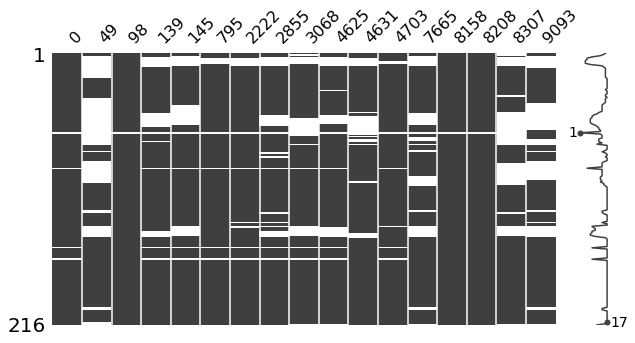

In [7]:
print("Visualizing missing value using bar graph")
print(mi.matrix(df_met_enh, figsize = (10,5)))

In [8]:
df_disease = pd.DataFrame(info['Disease'], df_met_enh.T.index, columns=['Disease'])
lut = dict(zip(np.unique(df_disease), ["r", "g"]))
row_colors = pd.DataFrame()
row_colors['Disease'] = df_disease.apply(lambda x: lut[x['Disease']], axis=1)

df_cell = pd.DataFrame(info['Cell'], df_met_enh.T.index, columns=['Cell'])
lut = dict(zip(np.unique(df_cell), "ygbcm"))
print(lut)
row_colors_2 = pd.DataFrame()
row_colors_2['Cell'] = df_cell.apply(lambda x: lut[x['Cell']], axis=1)

{'CD38-negative naive B cell': 'y', 'monocyte': 'g', 'plasma cell': 'b'}


In [9]:
def plot_heatmap(data, labels, min_value=0.26):
    fig, ax = plt.subplots(figsize=(10,6)) 
    ax = sns.heatmap(data, cmap=rvb, xticklabels=False, yticklabels=labels)
    ax.set_facecolor('#424949')

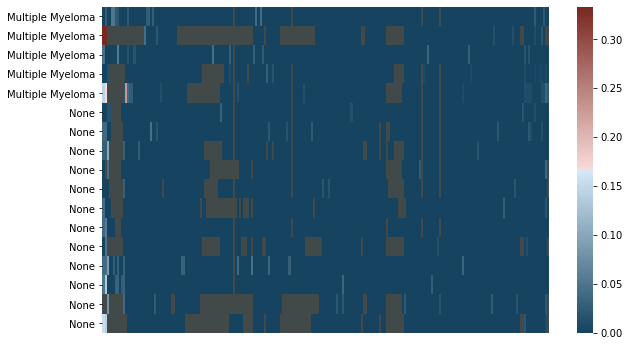

In [10]:
plot_heatmap(df_met_enh.T, df_disease["Disease"])

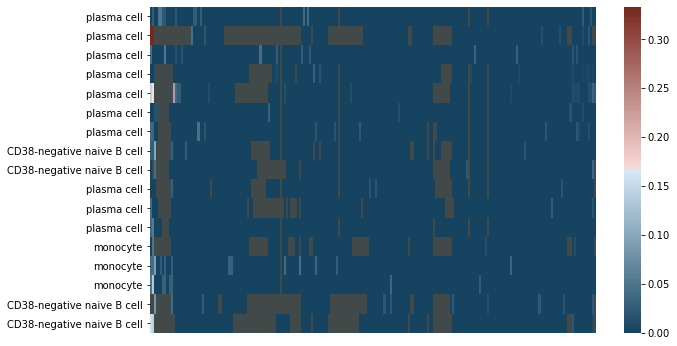

In [11]:
plot_heatmap(df_met_enh.T, df_cell["Cell"])


In [12]:
#Clustermap necesita rellanar los NA
df_met_enh_notnan = df_met_enh.fillna(0.0)

In [13]:
def plot_clustermap(data, row_colors):
    ax = sns.clustermap(data, cmap=rvb, col_cluster=False, row_colors=row_colors, metric="correlation")
    _ = plt.setp(ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)


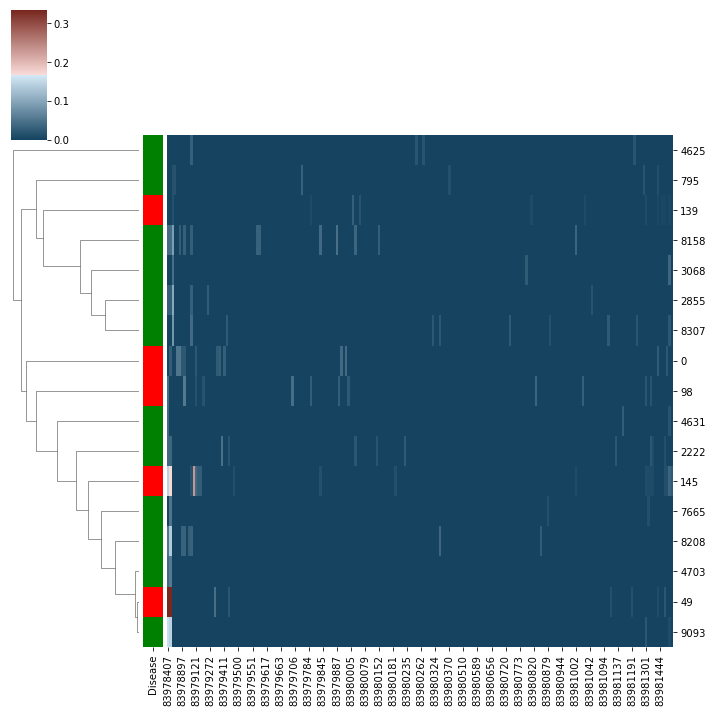

In [14]:
plot_clustermap(df_met_enh_notnan.T, row_colors)

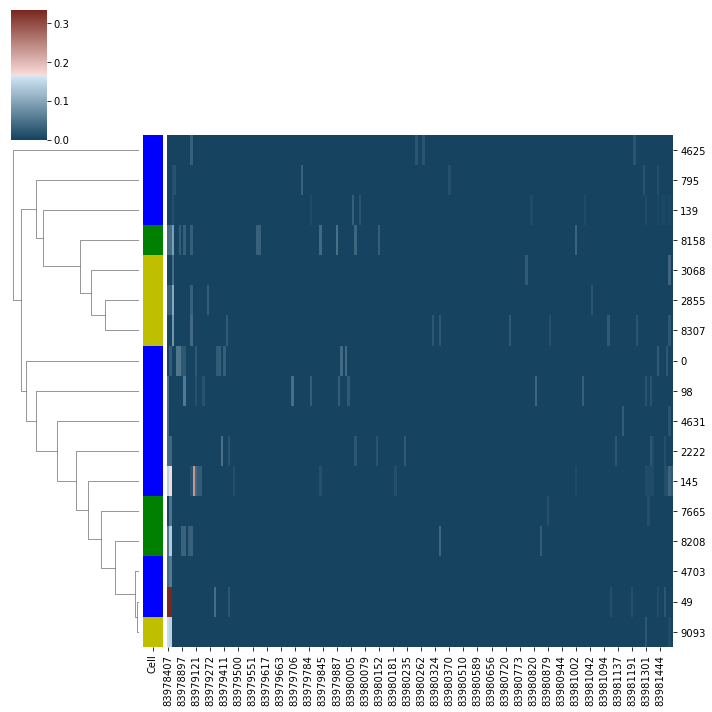

In [15]:
plot_clustermap(df_met_enh_notnan.T, row_colors_2)